In [1]:
import os, sys
import io
import requests
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from ipywidgets import IntProgress
from IPython.display import display

import skimage as ski
import cv2
import torch
import piq
import nvidia_smi

# local library of functions to connect to image server
import libutils.use_server as server

# Notebook to explore ideas for image metrics

In [2]:
img_path = server.init() 

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [3]:
files = server.get_list(img_path)
print("nombre de fichiers disponibles", len(files))
dirnames = []
for i in range(len(files)):
    dirnames.append(files[i].split('/')[4])
    
listdir = set(dirnames)
realdir = []
photo_not_in_dir = []
for ldir in listdir:
    if '.jpg' in ldir:
        photo_not_in_dir.append(ldir)
    else:
        realdir.append(ldir)

Status Code 200
nombre de fichiers disponibles 2268


In [4]:
files[0]

'/data/andra/calci_photos/REP2104/Photos/GTR2004-12_0017_REP2104_0065_0161.jpg'

In [5]:
sortedlist = sorted(realdir)

### The variance of the Laplacian can be a measure of the sharpness of the image, or the focus

In [6]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

### Magnitude of the gradient to get sharpness of edges

In [7]:
def gradient_magnitude(image):
    #Get magnitude of gradient for given image
    ddepth = cv2.CV_64F
    dx = cv2.Sobel(image, ddepth, 1, 0)
    dy = cv2.Sobel(image, ddepth, 0, 1)
    mag = cv2.magnitude(dx, dy)
    return mag

## Colour analysis
https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74

* First, we are using k-Means to cluster the top colors. Inside the function we are passing the value of how many clusters do we want to divide. Here is the documentation for K-Means clustering. After clustering we predict the colors that weigh the most — meaning getting the most area on the image.
* Secondly, we are calling the Counter function. Counter creates a container to the elements as dictionary keys, and their volume is store as dictionary values. If you are not familiar with dictionaries, they store data in key: value pairs. They are like function, and when you pass in the “key,” you can “value” as a return. Then we are ordering the colors according to the keys.

In [8]:
def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

def color_analysis(img):
    clf = KMeans(n_clusters = 5)  # 5 top colours
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i] for i in counts.keys()]
    return ordered_colors

### Function to read a directory and return some metrics

Bundle the metric calculation into one function. Add some Facebook metrics too: `piq` PyTorch Image Quality
* https://github.com/photosynthesis-team/piq/blob/master/examples/image_metrics.py

In [9]:
def read_directory(dirname, allfiles, quiet=True):
    """
    Function to read all images in a directory and return a data frame with image metrics
    
    parameters
    ----------
    dirname
        Name of directory to be read
    allfiles
        List of all files in the image server
        
    returns
    -------
    df
        Pandas dataframe of image metrics
    
    """
    ImageId = []
    Path = []
    FileName = []
    DrillName = []
    Cote0 = []
    Cote1 = []
    PxSize = []
    PySize = []
    Focus = []
    GradientMax = []
    GradientSTD = []
    Colour1 = []
    Colour2 = []
    Colour3 = []
    Colour4 = []
    Colour5 = []
    BRISQUE_i = []
    BRISQUE_l = []

    for file in allfiles:
        if dirname in file:
            img = server.get_file(file, quiet)
            #if img.size() > 89478485:
            #    continue
            l0 = file.split('/')[-1]
            l1 = l0.split('.')[0]
            l2 = l1.split('_')
            if len(l2)<3:
                continue
            width, height = img.size
            if width*height > 89478485:
                print(f'Not enough memory to process image {file} with PyTorch on local ')
            ImageId.append(0)
            Path.append(file)
            FileName.append(l0)
            DrillName.append(l2[-3])
            Cote0.append(l2[-2])
            Cote1.append(l2[-1])
            PxSize.append(width)
            PySize.append(height)

            # focus metric
            gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
            Focus.append(variance_of_laplacian(gray))
            
            # Gradient metric
            GradientMax.append(np.max(gradient_magnitude(gray)[:]))
            GradientSTD.append(np.std(gradient_magnitude(gray)[:]))
            
            # Top five colours
            try:
                colours = color_analysis(prep_image(np.asarray(img)))
                Colour1.append(colours[0])
                Colour2.append(colours[1])
                Colour3.append(colours[2])
                Colour4.append(colours[3])
                Colour5.append(colours[4])
            except:
                Colour1.append(np.nan)
                Colour2.append(np.nan)
                Colour3.append(np.nan)
                Colour4.append(np.nan)
                Colour5.append(np.nan)
            
            # pytorch image quality, use try, except loop to kep going if image is too large or does not conform
            try:
                x = torch.tensor(np.asarray(img)).permute(2, 0, 1)[None, ...] / 255.
                if torch.cuda.is_available():
                    # Move to GPU to make computaions faster
                    # print(torch.cuda.is_available())
                    x = x.cuda()
                brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')
                brisque_loss: torch.Tensor = piq.BRISQUELoss(data_range=1., reduction='none')(x)

                BRISQUE_i.append(brisque_index.item())
                BRISQUE_l.append(brisque_loss.item())
            except:
                print(f'Error in PyTorch with image {file}')
                BRISQUE_i.append(np.nan)
                BRISQUE_l.append(np.nan)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            del x


    d = {'ImageId':ImageId, 'Path':Path, 'FileName':FileName, 'DrillName':DrillName,
         'Cote0':Cote0, 'Cote1':Cote1, 'PxSize':PxSize, 'PySize':PySize, 'Focus':Focus,
         'Gradient max':GradientMax, 'Gradient std':GradientSTD, 'Colour1':Colour1, 'Colour2':Colour2, 'Colour3':Colour3, 
         'Colour4':Colour4, 'Colour5':Colour5, 'BRISQUE index':BRISQUE_i, 'BRISQUE loss':BRISQUE_l}
    df = pd.DataFrame(data=d)
    
    return df

In [10]:
df = read_directory(sortedlist[3], files)
df.sort_values('Cote0')

,ImageId,Path,FileName,DrillName,Cote0,Cote1,PxSize,PySize,Focus,Gradient max,Gradient std,Colour1,Colour2,Colour3,Colour4,Colour5,BRISQUE index,BRISQUE loss
3,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0000_0104.jpg,DCN2002,0000,0104,2988,621,37.517755,563.022202,33.627900,"[111.40377420430505, 97.86344216312992, 84.328...","[168.53212233634358, 129.66084920599167, 82.35...","[150.7340993597788, 153.82256982302852, 155.45...","[55.96788091278283, 49.980657237924376, 48.035...","[210.91008096977674, 211.99106965289934, 211.5...",26.670593,26.670593
1,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0078_0193.jpg,DCN2002,0078,0193,3456,633,138.378121,814.995706,63.625287,"[50.148086400077204, 45.94360948341145, 46.647...","[109.7182043861668, 99.94496715173307, 89.9608...","[172.92761447475993, 134.1830073779143, 94.831...","[139.72534869335612, 142.62519371853182, 143.2...","[211.34660105055568, 210.24333214339913, 206.7...",29.238464,29.238464
2,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0168_0288.jpg,DCN2002,0168,0288,3456,611,98.348385,742.172487,52.358199,"[94.07271323216273, 77.63285068920754, 63.8518...","[44.79256875364764, 40.578755851367205, 39.973...","[143.77489457862407, 142.92158339727138, 144.9...","[121.08720720166409, 112.96638248475992, 105.3...","[176.05760751372082, 177.73072281237418, 183.3...",25.632019,25.632019
0,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0260_0353.jpg,DCN2002,0260,0353,3234,624,54.526664,547.578305,39.212170,"[89.41297193358895, 77.03495913915316, 65.2576...","[49.707257614467764, 44.77815960291353, 41.328...","[116.1917347361615, 106.76876505664401, 101.21...","[139.74898883187444, 138.6448435456271, 140.50...","[179.3726428014337, 177.63776574449426, 179.71...",29.191589,29.191589


Status Code 200


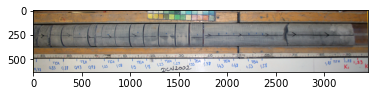

In [11]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


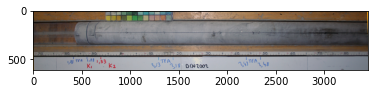

In [12]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()

### Plot by colour RGB

In [13]:
dfna = df.dropna()
colours = dfna['Colour1'].values
red = np.zeros((len(colours),))
green = np.zeros((len(colours),))
blue = np.zeros((len(colours),))
for i,colour in enumerate(colours):
    red[i] = colour[0]
    green[i] = colour[1]
    blue[i] = colour[2]

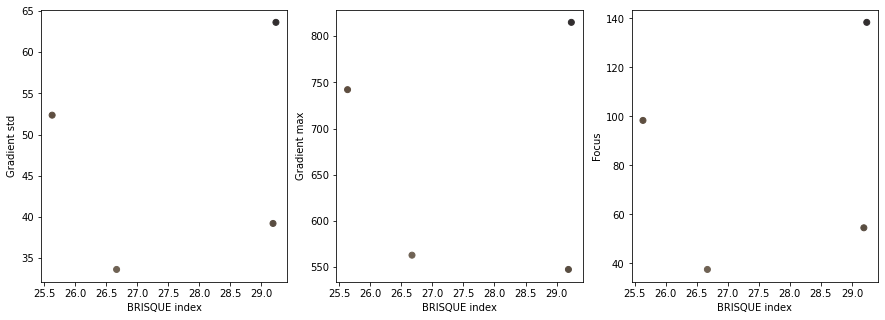

In [14]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.scatter(dfna['BRISQUE index'], dfna['Gradient std'], c=dfna['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient std')
plt.subplot(1,3,2)
plt.scatter(dfna['BRISQUE index'], dfna['Gradient max'], c=dfna['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient max')
plt.subplot(1,3,3)
plt.scatter(dfna['BRISQUE index'], dfna['Focus'], c=dfna['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Focus')
plt.show()

## Find the worst and best image by metrics

Run the function on all photos in the server (ignoring the ones that don't compute, they get `NaN`)

In [16]:
del df

if os.path.isfile('./BRISQUE_data.pkl') == False:
    
    max_count = len(sortedlist)

    f = IntProgress(min=0, max=max_count) # instantiate a progress bar
    display(f) # display the bar
    
    for i, directory in enumerate(sortedlist):

        #print(f'Going into {directory}, i={i}')
        if i == 0:
            df = read_directory(directory, files)
        else:
            _df = read_directory(directory, files)
            df = pd.concat([df, _df])

        """
        nvidia_smi.nvmlInit()
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
        # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        print("Free memory:", info.free)
        nvidia_smi.nvmlShutdown()
        """
        
        f.value += 1  # update progress bar

    df.to_pickle('./BRISQUE_data.pkl')
else:
    df = pd.read_pickle('./BRISQUE_data.pkl')
df = df.reset_index(drop=True)

IntProgress(value=0, max=102)

/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (150448179 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_4704_4780.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_4704_4780.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (159980904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_3953_4032.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_3953_4032.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (119789176 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_4655_4713.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_4655_4713.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (132907698 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_2490_2552.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2003/Photos/Photos/GTR2018-12_0028-IBE2003_2490_2552.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (140859675 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0194_0266.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0194_0266.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (146268261 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0520_0592.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0520_0592.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (130563384 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_2350_2415.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_2350_2415.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (120132616 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_2415_2470.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_2415_2470.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (132520600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0069_0135.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0069_0135.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (141939171 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0132_0201.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0132_0201.jpg


/work/armitagj/miniconda3/envs/ai.calcimetry/lib/python3.10/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (113727732 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Not enough memory to process image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0354_0409.jpg with PyTorch on local 
Error in PyTorch with image /data/andra/calci_photos/IBE2004/Photos/GTR2018-12_0028-IBE2004_0354_0409.jpg
Error in PyTorch with image /data/andra/calci_photos/OHZ5303/Photos/GTR2020-02_0003-OHZ5303_2289_2408.jpg
Error in PyTorch with image /data/andra/calci_photos/OHZ7004/Photos/FUG2020-06_0009-OHZ7004_2839_2943.jpg
Error in PyTorch with image /data/andra/Photos/FUG2020-06_0009-OHZ7004_2839_2943.jpg


In [17]:
dfna = df.dropna()

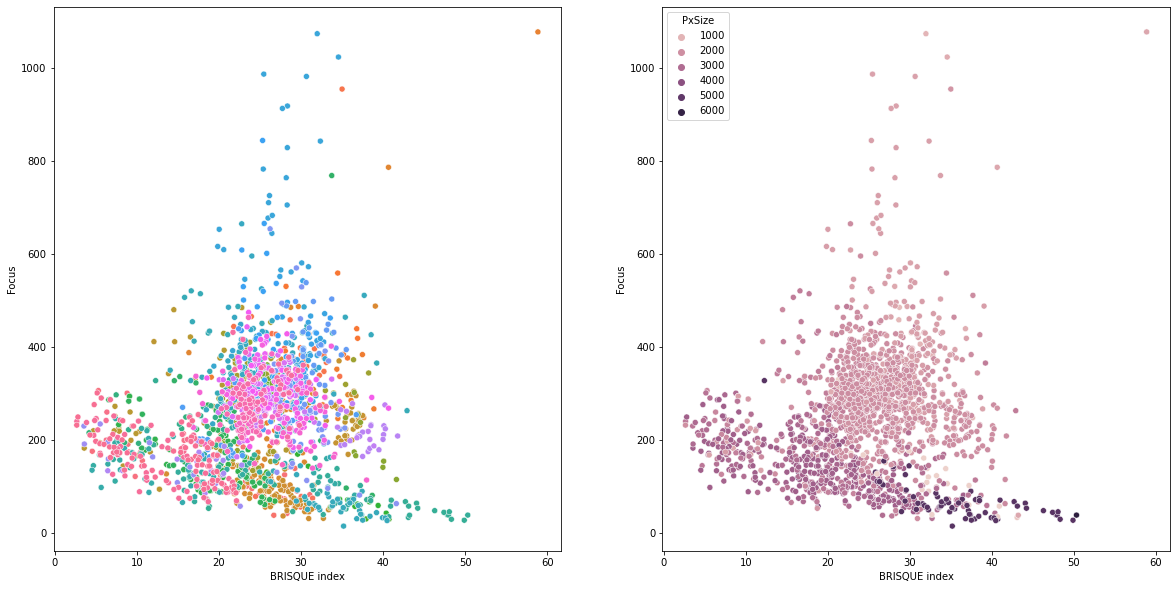

In [28]:
plt.figure(figsize=[20,10])
#ax = df.plot.scatter(x='BRISQUE index', y='Focus', c='DarkBlue')
plt.subplot(121)
ax = sns.scatterplot(data=dfna, x='BRISQUE index', y='Focus', hue='DrillName')
plt.legend([],[], frameon=False)
plt.subplot(122)
#ax = df.plot.scatter(x='BRISQUE index', y='Focus', c='DarkBlue')
ax = sns.scatterplot(data=dfna, x='BRISQUE index', y='Focus', hue='PxSize')
plt.show()
plt.show()

Status Code 200


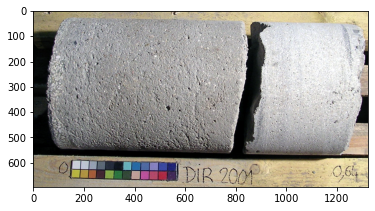

In [19]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


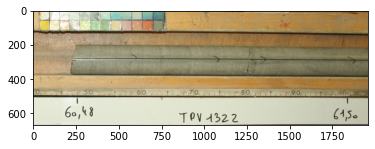

In [20]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()

Status Code 200


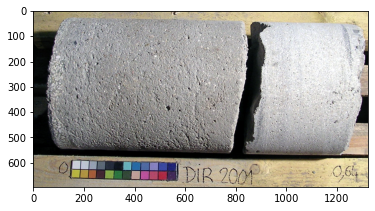

In [21]:
img = server.get_file(df['Path'][df['Focus'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


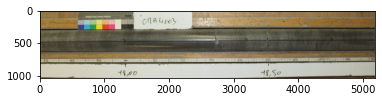

In [22]:
img = server.get_file(df['Path'][df['Focus'].idxmin()])
plt.imshow(img)
plt.show()

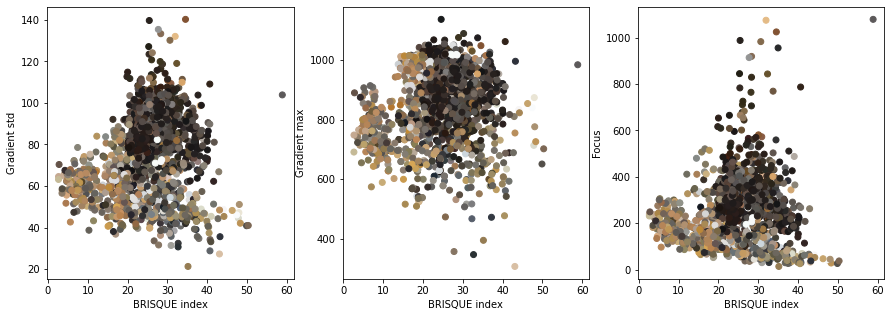

In [24]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.scatter(dfna['BRISQUE index'], dfna['Gradient std'], c=dfna['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient std')
plt.subplot(1,3,2)
plt.scatter(dfna['BRISQUE index'], dfna['Gradient max'], c=dfna['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient max')
plt.subplot(1,3,3)
plt.scatter(dfna['BRISQUE index'], dfna['Focus'], c=dfna['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Focus')
plt.show()

In [44]:
ten_worst = dfna.sort_values('Focus')['Path'][:10]

Status Code 200


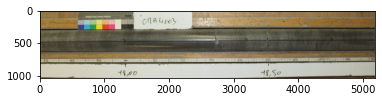

Status Code 200


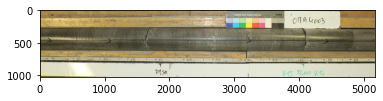

Status Code 200


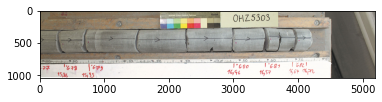

Status Code 200


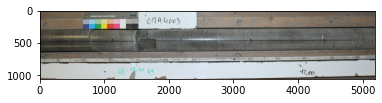

Status Code 200


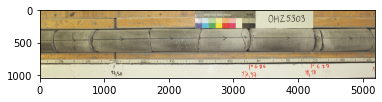

Status Code 200


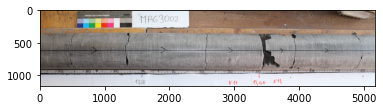

Status Code 200


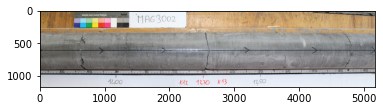

Status Code 200


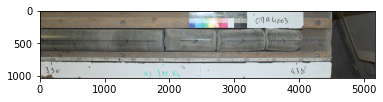

Status Code 200


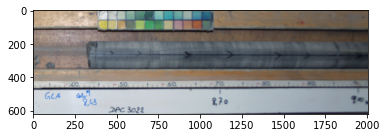

Status Code 200


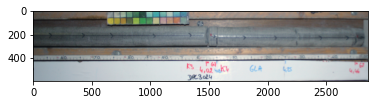

In [45]:
for file in list(ten_worst):
    img = server.get_file(file)
    plt.imshow(img)
    plt.show()